# Load libraries

In [1]:
import datetime
import pickle
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import sys
sys.path.append("..")
from RandomErasing import RandomErasing

import torchvision.models
from torchvision import transforms

from albumentations import Compose, ShiftScaleRotate, GridDistortion
from albumentations.pytorch import ToTensor

from torch.utils.tensorboard import SummaryWriter

/home/sai/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


In [2]:
# https://pytorch.org/docs/stable/tensorboard.html
current_time = datetime.datetime.now().replace(microsecond=0).isoformat()
tbwriter = SummaryWriter('../runs/master_code_{}'.format(current_time))

# Prepate the data

In [3]:
def prepare_data(df, unknown_to_known):
    df = df.reset_index()
    df['slno'] = df.assign(slno=1).groupby('audio_filename')['slno'].cumsum()
    df.set_index(['audio_filename', 'slno'], inplace=True)

    df_unknown = df.copy().loc[:, list(unknown_to_known.keys())]
    df.drop(columns=list(unknown_to_known.keys()), inplace=True)

    y_mask = df.copy()
    y_mask.loc[:, :] = 1
    for unknown, known in unknown_to_known.items():
        y_mask.loc[
            df_unknown[unknown] > 0.5,
            known
        ] = 0

    df = df.swaplevel(i=1, j=0, axis=0).sort_index()

    y_mask = y_mask.swaplevel(i=1, j=0, axis=0).sort_index()

    y = np.concatenate([
        df.loc[[1], :].values[..., np.newaxis],
        df.loc[[2], :].values[..., np.newaxis],
        df.loc[[3], :].values[..., np.newaxis]
    ], axis=2)

    y_mask = np.concatenate([
        y_mask.loc[[1], :].values[..., np.newaxis],
        y_mask.loc[[2], :].values[..., np.newaxis],
        y_mask.loc[[3], :].values[..., np.newaxis]
    ], axis=2)

    X = np.concatenate([
        np.expand_dims(np.load('../../data/logmelspec/{}.npy'.format(x)).T[:635, :], axis=0)
        for x in df.loc[[1], :].reset_index(1).audio_filename.tolist()])
    X = np.expand_dims(X, axis=1)

    return X, y, y_mask

In [4]:
# Load and prepare data
with open('../../data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

unknown_to_known = (
    pd.merge(metadata['taxonomy_df'].loc[lambda x: x.fine_id == 'X', ['fine', 'coarse']],
             metadata['taxonomy_df'].loc[lambda x: x.fine_id != 'X', ['fine', 'coarse']],
             on='coarse', how='inner')
    .drop(columns='coarse')
    .groupby('fine_x')['fine_y']
    .apply(lambda x: list(x)).to_dict())
known_labels = metadata['taxonomy_df'].loc[lambda x: x.fine_id != 'X'].fine.tolist()

train_df = pd.concat([metadata['coarse_train'], metadata['fine_train']], axis=1, sort=True)
valid_df = pd.concat([metadata['coarse_test'], metadata['fine_test']], axis=1, sort=True)

In [5]:
# manual correction for one data point
train_df.loc[(train_df.sum(axis=1) == 37).copy(), :] = 0
valid_df.loc[(valid_df.sum(axis=1) == 37).copy(), :] = 0

In [6]:
train_X, train_y, train_y_mask = prepare_data(train_df, unknown_to_known)
valid_X, valid_y, valid_y_mask = prepare_data(valid_df, unknown_to_known)

In [7]:
# Channel wise normalization
channel_means = train_X.reshape(-1, 128).mean(axis=0).reshape(1, 1, 1, -1)
channel_stds = train_X.reshape(-1, 128).std(axis=0).reshape(1, 1, 1, -1)
train_X = (train_X - channel_means) / channel_stds
valid_X = (valid_X - channel_means) / channel_stds

# Prepare the PyTorch datasets

In [8]:
random_erasing = RandomErasing()


class AudioDataset(Dataset):

    def __init__(self, X, y, weights, transform=None):
        self.X = X
        self.y = y
        self.weights = weights
        self.transform = transform
        self.pil = transforms.ToPILImage()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = self.X[idx, ...]

        if self.transform:
            # min-max transformation
            this_min = sample.min()
            this_max = sample.max()
            sample = (sample - this_min) / (this_max - this_min)

            # randomly cycle the file
            i = np.random.randint(sample.shape[1])
            sample = torch.cat([
                sample[:, i:, :],
                sample[:, :i, :]],
                dim=1)

            # apply albumentations transforms
            sample = np.array(self.pil(sample))
            sample = self.transform(image=sample)
            sample = sample['image']
            sample = sample[None, :, :].permute(0, 2, 1)

            # apply random erasing
            sample = random_erasing(sample.clone().detach())

            # revert min-max transformation
            sample = (sample * (this_max - this_min)) + this_min

        return sample, self.y[idx, ...], self.weights[idx, ...]


class Task5Model(nn.Module):

    def __init__(self, num_classes):

        super().__init__()

        self.bw2col = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
            nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())

        self.mv2 = torchvision.models.mobilenet_v2(pretrained=True)

        self.final = nn.Sequential(
            nn.Linear(1280, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Linear(512, num_classes))

    def forward(self, x):
        x = self.bw2col(x)
        x = self.mv2.features(x)
        x = x.max(dim=-1)[0].max(dim=-1)[0]
        x = self.final(x)
        return x

In [9]:
# Define the data augmentation transformations
albumentations_transform = Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0.5),
    GridDistortion(),
    ToTensor()
])

In [10]:
# Create the datasets and the dataloaders
train_dataset = AudioDataset(torch.Tensor(train_X),
                             torch.Tensor(train_y),
                             torch.Tensor(train_y_mask),
                             albumentations_transform)
valid_dataset = AudioDataset(torch.Tensor(valid_X),
                             torch.Tensor(valid_y),
                             torch.Tensor(valid_y_mask),
                             None)

val_loader = DataLoader(valid_dataset, 64, shuffle=False)
train_loader_1 = DataLoader(train_dataset, 64, shuffle=True, drop_last=True)
train_loader_2 = DataLoader(train_dataset, 64, shuffle=True, drop_last=True)

# Define the model

In [11]:
# Define the device to be used
cuda = True
device = torch.device('cuda:0' if cuda else 'cpu')
print('Device: ', device)

Device:  cuda:0


In [12]:
model = Task5Model(31).to(device)

In [13]:
model

Task5Model(
  (bw2col): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 10, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
  )
  (mv2): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2):

In [14]:
# Define optimizer, scheduler and loss criteria
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.BCEWithLogitsLoss(reduction='none')

# Training

In [15]:
cols = columns=[
        '1_engine', '2_machinery-impact', '3_non-machinery-impact',
        '4_powered-saw', '5_alert-signal', '6_music', '7_human-voice', '8_dog',
        '1-1_small-sounding-engine', '1-2_medium-sounding-engine',
        '1-3_large-sounding-engine', '2-1_rock-drill', '2-2_jackhammer',
        '2-3_hoe-ram', '2-4_pile-driver', '3-1_non-machinery-impact',
        '4-1_chainsaw', '4-2_small-medium-rotating-saw',
        '4-3_large-rotating-saw', '5-1_car-horn', '5-2_car-alarm', '5-3_siren',
        '5-4_reverse-beeper', '6-1_stationary-music', '6-2_mobile-music',
        '6-3_ice-cream-truck', '7-1_person-or-small-group-talking',
        '7-2_person-or-small-group-shouting', '7-3_large-crowd',
        '7-4_amplified-speech', '8-1_dog-barking-whining']

In [16]:
# from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/04-utils/tensorboard/main.py
for tag, value in model.named_parameters():
    tag = tag.replace('.', '/')
    tbwriter.add_histogram(tag, value.data.cpu().numpy(), -1)

In [17]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [18]:
epochs = 100
train_loss_hist = []
valid_loss_hist = []
lowest_val_loss = np.inf
epochs_without_new_lowest = 0
train_batch_slno=0

for i in range(epochs):
    print('Epoch: ', i)

    this_epoch_train_loss = 0
    for i1, i2 in zip(train_loader_1, train_loader_2):

        # mixup the inputs ---------
        alpha = 1
        mixup_vals = np.random.beta(alpha, alpha, i1[0].shape[0])

        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1, 1))
        inputs = (lam * i1[0]) + ((1 - lam) * i2[0])

        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1))
        labels = (lam * i1[1]) + ((1 - lam) * i2[1])
        masks = (lam * i1[2]) + ((1 - lam) * i2[2])
        # mixup ends ----------

        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            model = model.train()
            outputs = model(inputs)
            # calculate loss for each set of annotations
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            loss.backward()
            optimizer.step()
            this_epoch_train_loss += loss.detach().cpu().numpy()
            tbwriter.add_scalar('Loss/Batch/Train', loss.detach().cpu().numpy(), train_batch_slno)
            train_batch_slno += 1

    for tag, value in model.named_parameters():
        tag = tag.replace('.', '/')
        tbwriter.add_histogram(tag, value.data.cpu().numpy(), i)
        if value.grad is not None:
            tbwriter.add_histogram(tag + '/grad', value.grad.data.cpu().numpy(), i)
    
    this_epoch_valid_loss = 0
    val_labels, val_masks, val_outputs = [], [], []
    for inputs, labels, masks in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            this_epoch_valid_loss += loss.detach().cpu().numpy()
            
            val_labels.append(labels.detach().cpu().numpy())
            val_masks.append(masks.detach().cpu().numpy())
            val_outputs.append(outputs.detach().cpu().numpy())
    
    val_labels = np.concatenate(val_labels, axis=0)
    val_masks = np.concatenate(val_masks, axis=0)
    val_outputs = np.concatenate(val_outputs, axis=0)
    val_outputs = (1 / (1 + np.exp(-val_outputs)))
    for c, col in enumerate(cols):
        this_labels_stacked = np.concatenate([
            val_labels[c, :, 0], 
            val_labels[c, :, 1],
            val_labels[c, :, 2]
        ], axis=0)
        this_masks_stacked = np.concatenate([
            val_masks[c, :, 0], 
            val_masks[c, :, 1],
            val_masks[c, :, 2]
        ], axis=0)
        this_outputs_stacked = np.concatenate([
            val_outputs[c, :], 
            val_outputs[c, :],
            val_outputs[c, :]
        ], axis=0)
        this_labels_stacked = this_labels_stacked[(this_masks_stacked >= 0.5)]
        this_outputs_stacked = this_outputs_stacked[(this_masks_stacked >= 0.5)]
        tbwriter.add_pr_curve(
            'All/' + col,
            this_labels_stacked,
            this_outputs_stacked,
            global_step=i)
        tbwriter.add_scalar(
            'ROC/' + col,
            roc_auc_score(this_labels_stacked, this_outputs_stacked),
            i)
        tbwriter.add_scalar(
            'PRC/' + col,
            average_precision_score(this_labels_stacked, this_outputs_stacked),
            i)

    this_epoch_train_loss /= len(train_loader_1)
    this_epoch_valid_loss /= len(val_loader)

    train_loss_hist.append(this_epoch_train_loss)
    valid_loss_hist.append(this_epoch_valid_loss)

    if this_epoch_valid_loss < lowest_val_loss:
        lowest_val_loss = this_epoch_valid_loss
        torch.save(model.state_dict(), './model_system1')
        epochs_without_new_lowest = 0
    else:
        epochs_without_new_lowest += 1

    if epochs_without_new_lowest >= 25:
        break

    scheduler.step(this_epoch_valid_loss)
    
    print(this_epoch_train_loss, this_epoch_valid_loss)
    tbwriter.add_scalar('Loss/Epoch/Train', this_epoch_train_loss, i)
    tbwriter.add_scalar('Loss/Epoch/Valid', this_epoch_valid_loss, i)

Epoch:  0
0.639077944888009 0.5160171048981803
Epoch:  1
0.3370615045229594 0.16956102848052979
Epoch:  2
0.1786867305636406 0.14990040234157018
Epoch:  3
0.16375801753666666 0.13808726838656835
Epoch:  4
0.15955021108190218 0.14831802461828505
Epoch:  5
0.1581436623301771 0.13473899343184062
Epoch:  6
0.1547493976023462 0.13244217527764185
Epoch:  7
0.15298154453436533 0.13115739290203368
Epoch:  8
0.15668929740786552 0.1307528487273625
Epoch:  9
0.1553802134262191 0.12905768411500113
Epoch:  10
0.15311763476994303 0.13630103213446482
Epoch:  11
0.151903432690435 0.12587674600737436
Epoch:  12
0.15128415077924728 0.1476328351667949
Epoch:  13
0.15041223126980993 0.12556405046156474
Epoch:  14
0.14917510251204172 0.12610877411706106
Epoch:  15
0.1507811856766542 0.12592710767473494
Epoch:  16
0.14892479239238632 0.1255308293870517
Epoch:  17
0.15032986675699553 0.12657658968653
Epoch:  18
0.1490610068043073 0.12548682519367763
Epoch:  19
0.1484908014535904 0.12439964818102973
Epoch:  2

In [19]:
tbwriter.flush()

---

In [59]:
model.load_state_dict(torch.load('model_system1'))

<All keys matched successfully>

In [60]:
model = model.eval()

In [61]:
tmp = next(iter(val_loader))[0]

In [62]:
tmp.shape

torch.Size([64, 1, 635, 128])

In [64]:
tmp2 = model.bw2col(tmp.to(device))
tmp3 = next(iter(model.mv2.features.children()))[0](tmp2)

In [65]:
tmp2 = tmp2.detach().cpu()
tmp3 = tmp3.detach().cpu()
tmp2.shape, tmp3.shape

(torch.Size([64, 3, 635, 128]), torch.Size([64, 32, 318, 64]))

In [49]:
tbwriter.add_image('test/3/-1',tmp[1, 0, :, :], 100, dataformats='WH')
tbwriter.add_image('test/3/0', tmp2[1, 0, :, :], 100, dataformats='WH')
tbwriter.add_image('test/3/1', tmp2[1, 1, :, :], 100, dataformats='WH')
tbwriter.add_image('test/3/2', tmp2[1, 2, :, :], 100, dataformats='WH')

In [66]:
for i in range(32):
    tbwriter.add_image(
        'test/10/{}'.format(i),
        tmp3[0, i, :, :],
        100,
        dataformats='WH'
    )

In [55]:
tbwriter.add_image('test/3', tmp2[1, :, :, :].permute(0, 2, 1), 100)

In [46]:
import seaborn as sns
%matplotlib inline

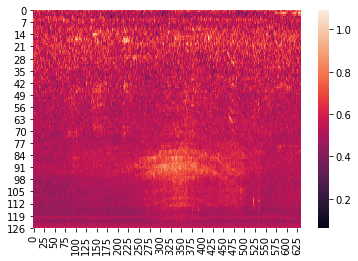

In [52]:
sns.heatmap(tmp2[1, 0, :, :].numpy().T)

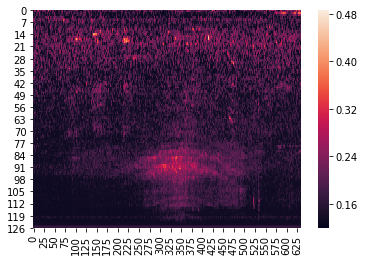

In [53]:
sns.heatmap(tmp2[1, 1, :, :].numpy().T)

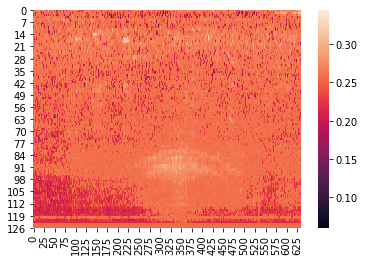

In [54]:
sns.heatmap(tmp2[1, 2, :, :].numpy().T)

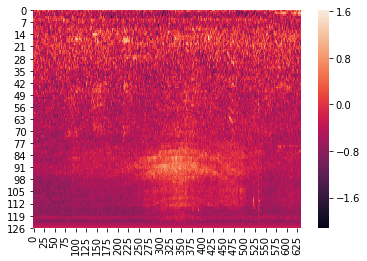

In [50]:
sns.heatmap(tmp[1, 0, :, :].numpy().T)

In [67]:
tbwriter.flush()

In [ ]:
x = self.bw2col(x)
        x = self.mv2.features(x)
        x = x.max(dim=-1)[0].max(dim=-1)[0]
        x = self.final(x)